# Grainstone Anomaly Detection: An Exploratory Study

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from skimage.feature import hog
from skimage import data, exposure

%matplotlib inline

In [3]:
root = '/Users/nicococo/Downloads/grainstone'

from PIL import Image
import glob
image_list = []
for filename in glob.glob(root + '/*.jpg'): 
    im = Image.open(filename)
    image_list.append(np.asarray(im.convert('F')).reshape(512*512))
    im.close()
data = np.asarray(image_list)

print(np.max(data), np.min(data))
data /= 255.
# data /= np.repeat(np.sum(data, axis=1)[:, np.newaxis], features, axis=1) 
    
print(data[:2,:10])

im_size = [512, 512]
samples = data.shape[0]
features = data.shape[1]
print(data.shape)


255.0 0.0
[[0.54921174 0.53744704 0.47082353 0.40807843 0.38454902 0.36494118
  0.37949806 0.43047845 0.40694904 0.36773336]
 [0.22717255 0.21932942 0.21540785 0.21148628 0.20841569 0.21233726
  0.21625882 0.2194549  0.22337647 0.21161176]]
(726, 262144)


In [4]:
def calc_rbf_kernel(X, Y=None, param=1.):
    if Y is None:
        Y = X
    Xn = X.shape[0]
    Yn = Y.shape[0]
    Dx = (np.ones((Yn, 1)) * np.diag(X.dot(X.T)).reshape(1, Xn)).T
    Dy = (np.ones((Xn, 1)) * np.diag(Y.dot(Y.T)).reshape(1, Yn))
    kernel = Dx - 2.* np.array(X.dot(Y.T)) + Dy
    kernel = np.exp(-kernel / param)    
    return kernel

In [5]:
def calc_hist_intersect_kernel(X, Y=None):
    if Y is None:
        Y = X
    kernel = np.zeros((X.shape[0], Y.shape[0]))
    for i in range(X.shape[0]):
        v = X[i, :]
        kernel[i, :] = 0.5*np.sum(v.dot(X.T) + Y.dot(X.T) - np.abs(v.dot(X.T) - Y.dot(X.T)), axis=1)
    return kernel

In [6]:
def calc_hog_features(X):
    X_hog_list = []
    for i in range(X.shape[0]):
        image = X[i, :].reshape(im_size[0], im_size[1])
        fv = hog(image, orientations=16, pixels_per_cell=(8, 8), feature_vector=True, \
                    cells_per_block=(1, 1), visualize=False, multichannel=False, block_norm='L2-Hys')
        fv /= np.linalg.norm(fv)
        X_hog_list.append(fv)
    print('Number of HOG features: ', fv.size)
    return np.asarray(X_hog_list)

In [7]:
def calc_histogram_features(X, bins=10, normalize=False):
    num_samples, num_features = X.shape
    transformed_data = np.zeros((num_samples, bins))
    for i in range(num_samples):
        transformed_data[i, :], _ = np.histogram(X[i, :], bins=bins, range=(0., 1.), density=normalize)
        transformed_data[i, :] /= bins
    return transformed_data

In [8]:
def one_class_svm_nu_one(kernel):
    return np.sum(kernel, axis=0)/kernel.shape[0]

In [9]:
NUM_TRAIN_SAMPLES = 200
RBF_PARAM = 1.
BINS = 10

# train = calc_histogram_features(data, bins=BINS)
train = calc_hog_features(data)
train_inds = np.random.permutation(samples)[:NUM_TRAIN_SAMPLES]

# kernel = calc_rbf_kernel(train[train_inds, :], train, param=RBF_PARAM)
# kernel = calc_hist_intersect_kernel(train[train_inds, :], train)
kernel = train[train_inds, :].dot(train.T)

print(kernel.shape)
outlier_scores = one_class_svm_nu_one(kernel)
outlier_ranking = np.argsort(-outlier_scores)
print(outlier_scores.shape)
print('Memory footprint of your RBF matrix ({0}x{1} elements): {2}MB'.format(
    kernel.shape[0], kernel.shape[1], np.int(kernel.size*kernel.itemsize / (1024.*1024.))))


Number of HOG features:  65536
(200, 726)
(726,)
Memory footprint of your RBF matrix (200x726 elements): 1MB


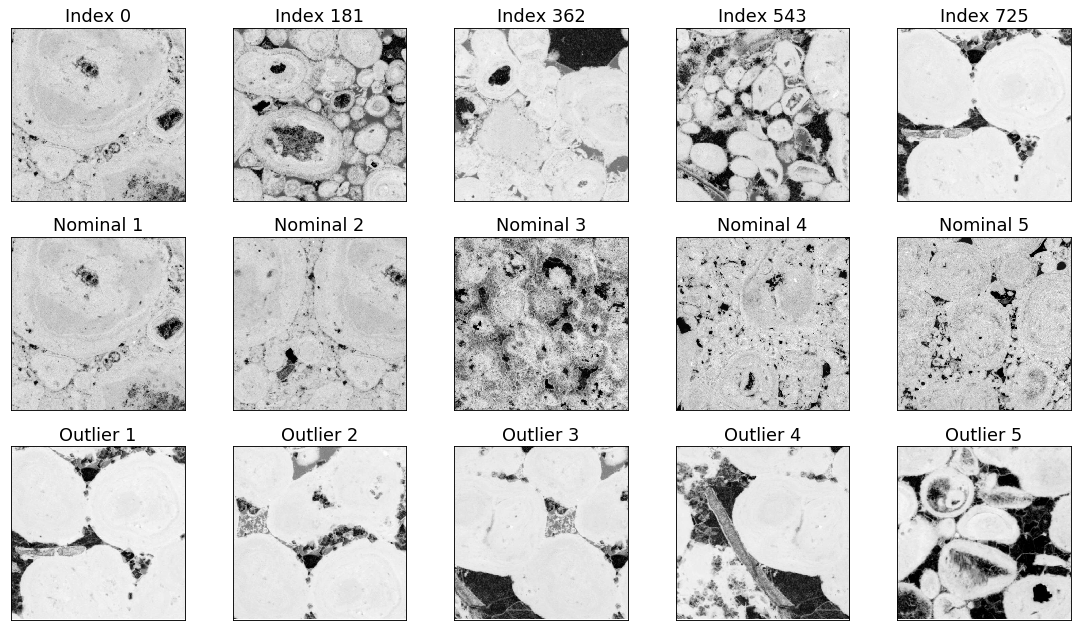

In [10]:
fig = plt.figure(figsize=(14, 8), dpi=80, facecolor='w', edgecolor='k')

inds = np.linspace(0, train.shape[0]-1, 5).astype(np.int)
for i in range(5):
    plt.subplot(3, 5, 1+i)
    plt.title('Index {0}'.format(inds[i]), fontsize=16)
    plt.imshow(data[outlier_ranking[inds[i]], :].reshape(im_size[0], im_size[1]), cmap='binary')
    plt.xticks([], [], fontsize=14)
    plt.yticks([], [], fontsize=14)

for i in range(5):
    plt.subplot(3, 5, 6+i)
    plt.title('Nominal {0}'.format(i+1), fontsize=16)
    plt.imshow(data[outlier_ranking[i], :].reshape(im_size[0], im_size[1]), cmap='binary')
    plt.xticks([], [], fontsize=14)
    plt.yticks([], [], fontsize=14)
    
for i in range(5):
    plt.subplot(3, 5, 11+i)
    plt.title('Outlier {0}'.format(i+1), fontsize=16)
    plt.imshow(data[outlier_ranking[-(i+1)], :].reshape(im_size[0], im_size[1]), cmap='binary')
    plt.xticks([], [], fontsize=14)
    plt.yticks([], [], fontsize=14)

fig.tight_layout()

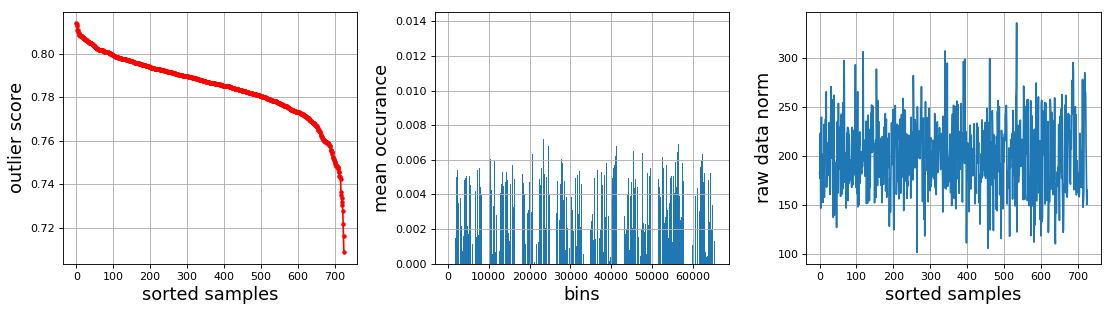

In [11]:
fig = plt.figure(figsize=(14, 4), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1, 3, 1)
plt.plot(np.arange(outlier_ranking.size), outlier_scores[outlier_ranking], '.-r')
plt.grid(True)
plt.xlabel('sorted samples', fontsize=16)
plt.ylabel('outlier score', fontsize=16)

plt.subplot(1, 3, 2)
plt.bar(np.arange(train.shape[1]), train[1, :])
plt.grid(True)
plt.xlabel('bins', fontsize=16)
plt.ylabel('mean occurance', fontsize=16)

plt.subplot(1, 3, 3)
plt.plot(np.arange(samples), np.linalg.norm(data[outlier_ranking, :], axis=1))
plt.grid(True)
plt.xlabel('sorted samples', fontsize=16)
plt.ylabel('raw data norm', fontsize=16)


fig.tight_layout()